In [1]:
#import our library
import copy
import numpy as np
import scipy.sparse
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split 
from sklearn import preprocessing
from sklearn.metrics import accuracy_score

In [2]:
#Zero_Ones Function for Our y( or target)
def to_zero_ones(y):
    yfmin = y==y.min()
    yfmax = y==y.max()
    y[yfmin] = 0
    y[yfmax] = 1    
    return y

In [3]:
#get Our dataset and split & change to matrix for 3 Function we use
def get_data():
    iris_data = load_iris()
    train_data = np.hstack((iris_data['data'], np.asmatrix(iris_data['target']).T))
    test_data = np.hstack((iris_data['data'], np.asmatrix(iris_data['target']).T))
    
    x = train_data[:,0:4]
    y = train_data[:,4]
    xtest = test_data[:,0:4]
    ytest = test_data[:,4]
    
    x = preprocessing.scale(x)
    
    x, xtest, y, ytest = train_test_split(x, y, test_size = 0.20, random_state = 0) 
    
    train_data = np.append(x, y, 1)
    test_data = np.append(xtest, ytest, 1)
    
    return train_data, test_data

def get_data2():
    iris_data = load_iris()
    train_data = np.hstack((iris_data['data'], np.asmatrix(iris_data['target']).T))
    test_data = np.hstack((iris_data['data'], np.asmatrix(iris_data['target']).T))
    
    x = train_data[:,0:4]
    y = train_data[:,4]
    xtest = test_data[:,0:4]
    ytest = test_data[:,4]
    
    x = preprocessing.scale(x)
    train_data[:,0:4] = preprocessing.scale(train_data[:,0:4])

    x, xtest, y, ytest = train_test_split(x, y, test_size = 0.20, random_state = 454) 
    
    train_data = np.append(train_data[:,0:4], train_data[:,4], 1)
    test_data = np.append(xtest, ytest, 1)
    
    return train_data, test_data

def get_data3():
    iris_data = load_iris()
    train_data = np.hstack((iris_data['data'], np.asmatrix(iris_data['target']).T))
    test_data = np.hstack((iris_data['data'], np.asmatrix(iris_data['target']).T))
    
    x = train_data[:,0:4]
    y = train_data[:,4]
    xtest = test_data[:,0:4]
    ytest = test_data[:,4]
    
    x = preprocessing.scale(x)
    
    x, xtest, y, ytest = train_test_split(x, y, test_size = 0.20, random_state = 0) 
    
    train_data = np.append(x, y, 1)
    test_data = np.append(xtest, ytest, 1)
    
    return train_data, test_data

In [4]:
#preprocessing our datasets ( for 3 functions) 
#---------------------------------------------------------------
#OVA processing function
def preprocess_data(p_train_data, p_test_data, ex_class=None):
    if ex_class is not None:
        class_filter = np.transpose(p_train_data[:,4]==ex_class)
        other_filter = np.transpose(p_train_data[:,4]!=ex_class)
        p_train_data[other_filter.A1,4]=0.
        p_train_data[class_filter.A1,4]=1.
        #print(to_zero_ones(p_train_data[:,4]))        
    
    x = p_train_data[:,0:4]
    y = p_train_data[:,4]
    xtest = p_test_data[:,0:4]
    ytest = p_test_data[:,4]
    
    ones = np.ones((x.shape[0],1)).astype(np.float)
    onestest = np.ones((xtest.shape[0],1)).astype(np.float)
    one_x = np.append(ones, x, 1).astype(np.float)
    one_xtest = np.append(onestest, xtest, 1).astype(np.float)

    m, n = one_x.shape
    theta = np.zeros((1,n)).astype(np.float)
    theta = theta.T   
    return x, y, xtest, ytest, one_x, one_xtest, m, n, theta
#-------------------------------------------------------------------------------------------
#OVO preprocessing Function
def preprocess_data2(p_train_data, p_test_data, class1, class2):
    class1_filter = np.transpose(p_train_data[:,4]==class1)
    class2_filter = np.transpose(p_train_data[:,4]==class2)
    train_data_class1 = p_train_data[class1_filter.A1,:]
    train_data_class2 = p_train_data[class2_filter.A1,:]
    train_data_class1[:,4]=1.
    train_data_class2[:,4]=0.
    p_train_data = np.append(train_data_class1,train_data_class2,0)                                   
    
    x = p_train_data[:,0:4]
    y = p_train_data[:,4]
    xtest = p_test_data[:,0:4]
    ytest = p_test_data[:,4]
    
    ones = np.ones((x.shape[0],1))
    onestest = np.ones((xtest.shape[0],1))

    one_x = np.append(ones, x, 1)
    one_xtest = np.append(onestest, xtest, 1)

    m, n = one_x.shape
    theta = np.zeros((1,n)).astype(np.float)
    theta = theta.T 
    return x, y, xtest, ytest, one_x, one_xtest, m, n, theta
#-------------------------------------------------------------------------
#softmax preprocessing Function
def preprocess_data3(p_train_data, p_test_data, class_num):
    
    x = p_train_data[:,0:4]
    y = p_train_data[:,4].astype(np.int)
    xtest = p_test_data[:,0:4]
    ytest = p_test_data[:,4].astype(np.int)
    
    ones = np.ones((x.shape[0],1)).astype(np.float)
    onestest = np.ones((xtest.shape[0],1)).astype(np.float)

    one_x = np.append(ones, x, 1).astype(np.float)
    one_xtest = np.append(onestest, xtest, 1).astype(np.float)

    m, n = one_x.shape
    theta = np.zeros((class_num,n)).astype(np.float)
    theta = theta.T
    
    return x, y, xtest, ytest, one_x, one_xtest, m, n, theta

In [5]:
#Define our main functions for this homework
#------------------------------------------------------
#hypothesis function(h(theta))
def hypo(xx,tt):
    h = 1/(1+np.exp(-np.matmul(xx, tt)))
    #print('hypo=',h)
    return h

#cost function(J(theta)=c)
def cost(xx, yy, tt):
    m = xx.shape[0]
    h = hypo(xx,tt)
    c = (1/m)*(-yy.T*np.log10(h) - (1 - yy).T*np.log10(1 - h))
    #print('cost=',c)
    return c


#Gradiant function
def iterate(loops, alpha, x, y, theta, m):
    mse = np.zeros((loops,2))
    r = 0    
    y = to_zero_ones(y)    
        
    while r < loops:
        h = hypo(x, theta)
        theta = theta - (alpha/m)*x.T*(h - y)
        
        mse[r,0] = r
        mse[r,1] = cost(x, y, theta)
        
        r += 1
    
    return theta, mse

#prediction function
def get_preds(someX, w):
    probs = softmax(np.dot(someX,w))
    preds = np.argmax(probs,axis=1)
    return probs,preds


#confusion matrix function (Accuracy)
def getAccuracy(someX,someY,w):
    prob,prede = get_preds(someX, w)
    accuracy = sum(prede == someY)/(float(len(someY)))
    return accuracy

#onehot key function
def to_onehot(Y):
    m = Y.shape[0]
    #Y = Y[:,0]
    OHX = scipy.sparse.csr_matrix((np.ones(m), (Y.A1, np.array(range(m)))))
    OHX = np.array(OHX.todense()).T
    return OHX


#softmax function
def softmax(z):
    z -= np.max(z)
    return np.exp(z) / np.sum(np.exp(z))


#loss Fuction
def get_loss(w,x,y):
    m = x.shape[0]     
    y_mat = to_onehot(y)
    scores = np.dot(x,w)
    prob = softmax(scores)
    #print(w.shape)
    loss = (-1 / m) * np.sum(y_mat.T * np.log(prob))
    grad = (-1 / m) * np.dot(x.T,(y_mat - prob))
    return loss,grad

Multi Class Logistic Regression : One-Vs-All
Number Of Iteration =  10000
Learning Rate =  0.01
Train_Accuracy =  0.9166666666666666
Test_Accuracy  =  0.9


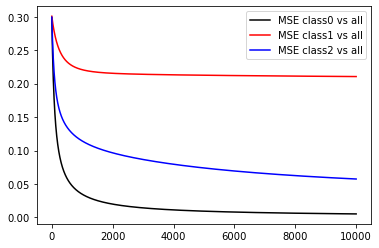

In [6]:
#our OVA function
def one_v_all(loops=10000, alpha=0.01):

    train_datas, test_datas = get_data()
    x, y, xtest, ytest, one_x, one_xtest, m, n, theta = preprocess_data(copy.deepcopy(train_datas), 
                                                                            copy.deepcopy(test_datas), 0)
    
    theta0, mse0 = iterate(loops, alpha, one_x, y, theta, m)
    x, y, xtest, ytest, one_x, one_xtest, m, n, theta = preprocess_data(copy.deepcopy(train_datas), 
                                                                            copy.deepcopy(test_datas), 1)

    theta1, mse1 = iterate(loops, alpha, one_x, y, theta, m)
    x, y, xtest, ytest, one_x, one_xtest, m, n, theta = preprocess_data(copy.deepcopy(train_datas), 
                                                                            copy.deepcopy(test_datas), 2)

    theta2, mse2 = iterate(loops, alpha, one_x, y, theta, m)    
    y_pred0 = hypo(one_x, theta0)
    y_pred1 = hypo(one_x, theta1)
    y_pred2 = hypo(one_x, theta2)
    y_pred_train = np.append(np.append(y_pred0, y_pred1, 1),y_pred2,1).argmax(axis=1)
    train_accuracy = accuracy_score(train_datas[:,4], y_pred_train)
    #----------------------------------------------------------------------------------
    y_pred_test0 = hypo(one_xtest, theta0)
    y_pred_test1 = hypo(one_xtest, theta1)
    y_pred_test2 = hypo(one_xtest, theta2)    
    y_pred_test = np.append(np.append(y_pred_test0, y_pred_test1, 1),y_pred_test2,1).argmax(axis=1)
    test_accuracy = accuracy_score(test_datas[:,4], y_pred_test)
    #-------------------------------------------------------------- 
    print('Multi Class Logistic Regression : One-Vs-All')
    print('Number Of Iteration = ',loops)
    print('Learning Rate = ',alpha)
    print('Train_Accuracy = ',train_accuracy)
    print('Test_Accuracy  = ',test_accuracy) 

#------------------------------------------------------------------------------------------    
    plt.plot(mse0.T[0], mse0.T[1], color = "black", label = 'MSE class0 vs all') 
    plt.plot(mse1.T[0], mse1.T[1], color = "red", label = 'MSE class1 vs all') 
    plt.plot(mse2.T[0], mse2.T[1], color = "blue", label = 'MSE class2 vs all') 
    plt.legend(loc = 'upper right')
    plt.show()

  

one_v_all(10000,0.01)  

Multi Class Logistic Regression : One-Vs-One
Number Of Iteration =  10000
Learning Rate =  0.01
Train_Accuracy =  1.0
Test_Accuracy  =  0.5


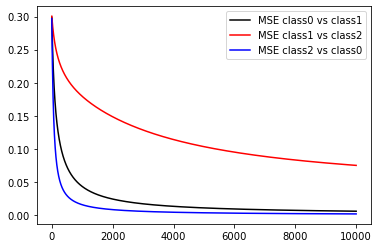

In [7]:
#our OVO Function
def one_v_one(loops=10000, alpha=0.01):

    train_datas, test_datas = get_data2()
    z = np.zeros((train_datas.shape[0],3)).astype(np.float)
    o = np.ones((train_datas.shape[0],1)).astype(np.float)
    train_preds = np.append(np.append(o,train_datas,1),z,1)
    
    zz = np.zeros((test_datas.shape[0],3)).astype(np.float)
    oo = np.ones((test_datas.shape[0],1)).astype(np.float)
    test_preds = np.append(np.append(oo,test_datas,1),zz,1)
    #print(test_preds.shape)

    x, y, xtest, ytest, one_x, one_xtest, m, n, theta = preprocess_data2(copy.deepcopy(train_datas), 
                                                                             copy.deepcopy(test_datas), 0, 1)
    theta0, mse0 = iterate(loops, alpha, one_x, y, theta, m)
    y_pred0 = hypo(one_x, theta0)
    y_pred_test0 = hypo(one_xtest, theta0)

#train data--------------------------------------------------------------
    for i in range(0,m):
        for j in range(0,train_preds.shape[0]):
            is_found = True
            for k in range(0,n):
                if train_preds[j,k]!=one_x[i,k]:
                    is_found = False
            if is_found == True:
                train_preds[j,5] = y[i]
                train_preds[j,6] = y_pred0[i]
#test data--------------------------------------------------------------
    for i in range(0,test_datas.shape[0]):
        for j in range(0,test_preds.shape[0]):
            is_found = True
            for k in range(0,n):
                if test_preds[j,k]!=one_xtest[i,k]:
                    is_found = False
            if is_found == True:
                test_preds[j,5] = ytest[i]
                test_preds[j,6] = y_pred_test0[i]
#----------------------------------------------------------------------------------------------------------------------
    x, y, xtest, ytest, one_x, one_xtest, m, n, theta = preprocess_data2(copy.deepcopy(train_datas),
                                                                             copy.deepcopy(test_datas), 1, 2)
    theta1, mse1 = iterate(loops, alpha, one_x, y, theta, m)
    y_pred1 = hypo(one_x, theta1)
    y_pred_test1 = hypo(one_xtest, theta1)

#train data-------------------------------------------------------
    for i in range(0,m):
        for j in range(0,train_preds.shape[0]):
            is_found = True
            for k in range(0,n):
                if train_preds[j,k]!=one_x[i,k]:
                    is_found = False
            if is_found == True:
                train_preds[j,5] = y[i]
                train_preds[j,7] = y_pred1[i]
#test data----------------------------------------------------------
    for i in range(0,test_datas.shape[0]):
        for j in range(0,test_preds.shape[0]):
            is_found = True
            for k in range(0,n):
                if test_preds[j,k]!=one_xtest[i,k]:
                    is_found = False
            if is_found == True:
                test_preds[j,5] = ytest[i]
                test_preds[j,7] = y_pred_test1[i]
#-----------------------------------------------------------------------------------------------------------------
    x, y, xtest, ytest, one_x, one_xtest, m, n, theta = preprocess_data2(copy.deepcopy(train_datas),
                                                                             copy.deepcopy(test_datas), 2, 0)
                                                                                     
    theta2, mse2 = iterate(loops, alpha, one_x, y, theta, m)   
    y_pred2 = hypo(one_x, theta2)
    y_pred_test2 = hypo(one_xtest, theta2)  
#train data----------------------------------------------------------------
    for i in range(0,m):
        for j in range(0,train_preds.shape[0]):
            is_found = True
            for k in range(0,n):
                if train_preds[j,k]!=one_x[i,k]:
                    is_found = False
            if is_found == True:
                train_preds[j,5] = y[i]
                train_preds[j,8] = y_pred2[i]
#test data----------------------------------------------------------------
    for i in range(0,test_datas.shape[0]):
        for j in range(0,test_preds.shape[0]):
            is_found = True
            for k in range(0,n):
                if test_preds[j,k]!=one_xtest[i,k]:
                    is_found = False
            if is_found == True:
                test_preds[j,5] = ytest[i]
                test_preds[j,8] = y_pred_test2[i]
#------------------------------------------------------------------------------------------
#train data----------------------------------------------------------------
    for i in range(0,train_datas.shape[0]):
        for j in range(0,train_preds.shape[0]):
            is_found = True
            for k in range(0,n-2):
                if train_preds[j,k+1]!=train_datas[i,k]:
                    is_found = False                    
            if is_found == True:
                train_preds[j,5] = train_datas[i,4]
#test data-------------------------------------------------------------------
    for i in range(0,test_datas.shape[0]):
        for j in range(0,test_preds.shape[0]):
            is_found = True
            for k in range(0,n-2):
                if test_preds[j,k+1]!=test_datas[i,k]:
                    is_found = False                    
            if is_found == True:
                test_preds[j,5] = test_datas[i,4] 
     
    y_pred_train = np.append(np.append(train_preds[:,6], train_preds[:,7], 1),train_preds[:,8],1).argmax(axis=1)
    train_accuracy = accuracy_score(train_datas[:,4], y_pred_train)
     
    y_pred_test = np.append(np.append(test_preds[:,6], test_preds[:,7], 1),test_preds[:,8],1).argmax(axis=1)
    test_accuracy = accuracy_score(test_datas[:,4], y_pred_test)

    #-----------------------------------------------------------------------------------------------------------------

    print('Multi Class Logistic Regression : One-Vs-One')
    print('Number Of Iteration = ',loops)
    print('Learning Rate = ',alpha)
    print('Train_Accuracy = ',train_accuracy)
    print('Test_Accuracy  = ',test_accuracy) 

    plt.plot(mse0.T[0], mse0.T[1], color = "black", label = 'MSE class0 vs class1') 
    plt.plot(mse1.T[0], mse1.T[1], color = "red", label = 'MSE class1 vs class2') 
    plt.plot(mse2.T[0], mse2.T[1], color = "blue", label = 'MSE class2 vs class0') 
    plt.legend(loc = 'upper right')
    plt.show()
   

one_v_one(10000,0.01)

Multi Class Logistic Regression : SoftMax
Number Of Iteration =  10000
Learning Rate =  0.01
Train_Accuracy =  [[0.8]]
Test_Accuracy  =  [[0.66666667]]


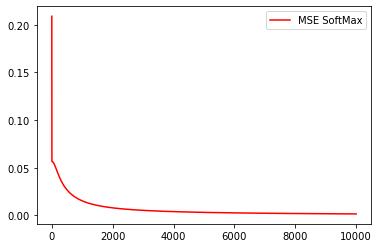

In [8]:
#our softmax function
def soft_max(loops=10000, alpha=0.01):
    train_datas, test_datas = get_data3()
    
    class_num = 3
    x, y, xtest, ytest, one_x, one_xtest, m, n, theta = preprocess_data3(copy.deepcopy(train_datas), 
                                                                         copy.deepcopy(test_datas), class_num)
    
    x = one_x
    xtest = one_xtest  
    w = np.zeros([x.shape[1],len(np.unique(y))])     
    mse = np.zeros((loops,2))
    r = 0
    #losses = []
    for i in range(0,loops):
        loss,grad = get_loss(w,x,y)
        #losses.append(1/loss)
        w = w - (alpha * grad)
        
        mse[i,0] = i
        mse[i,1] = 1/loss
   
    train_accuracy = getAccuracy(x,y,w)
    test_accuracy = getAccuracy(xtest,ytest,w)


    print('Multi Class Logistic Regression : SoftMax')
    print('Number Of Iteration = ',loops)
    print('Learning Rate = ',alpha)
    print('Train_Accuracy = ',train_accuracy)
    print('Test_Accuracy  = ',test_accuracy) 

    plt.plot(mse.T[0], mse.T[1], color = "red", label = 'MSE SoftMax')
    plt.legend(loc = 'upper right')
    plt.show()

soft_max(10000,0.01)